In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), # Added payments.csv for specific handling
    ('order_items.csv','order _items') 
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rohit@5267',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Rohit/Desktop/E-Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [9]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db=mysql.connector.connect(host='localhost',
                           username='root',
                           password='Rohit@5267',
                           database='ecommerce')

cur=db.cursor()





# Basic Queries

1. List all unique cities where customers are located.    




In [82]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host='localhost',
                           username='root',
                           password='Rohit@5267',
                           database='ecommerce')

cur=db.cursor()

query="""select distinct customer_city from customers"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


2. Count the number of orders in 2017

In [20]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data=cur.fetchall()
data[0][0]

45101

3. Find the total sales per category

In [41]:
query="""select upper(products.product_category) category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


4. Calculate the percentage of orders that were paid in installments

In [57]:
query = """select sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments"""

cur.execute(query)

data=cur.fetchall()
data[0][0]

Decimal('99.9981')

5. Count the number of customers from each state

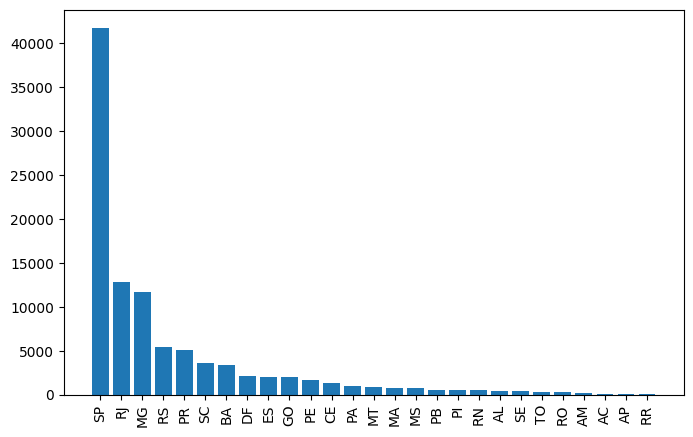

In [77]:
query="""select customer_state,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['State','Customers'])
df=df.sort_values(by="Customers",ascending=False)
plt.figure(figsize=(8,5))
plt.bar(df["State"],df["Customers"])
plt.xticks(rotation=90)
plt.show()

# Intermediate Queries

1. Calculate the number of orders per month in 2018

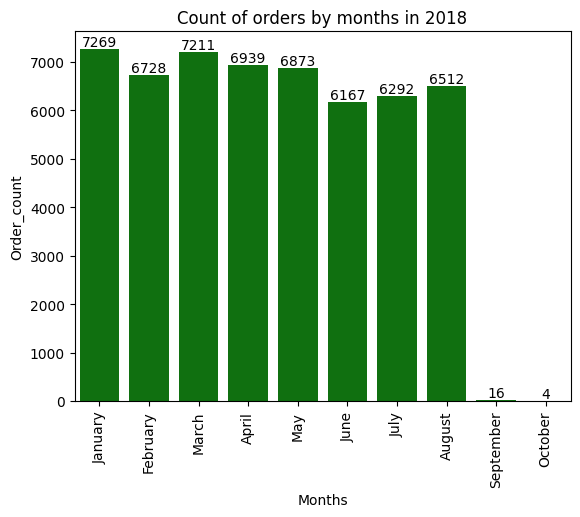

In [113]:
query="""select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders
where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Months","Order_count"])
df
o=["January","February","March","April","May","June","July","August","September","October"]

a=sns.barplot(x=df["Months"],y=df["Order_count"],data=df,order=o,color="Green")
plt.xticks(rotation=90)
a.bar_label(a.containers[0])
plt.title("Count of orders by months in 2018")
plt.show()

2. Find the average numbers of products per order, grouped by customer city

In [116]:
query="""with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,avg(count_per_order.oc)
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["City","Avg orders/customers"])
df.head(10)

,City,Avg orders/customers
0,sao jose dos campos,1.1385
1,indaial,1.1154
2,treze tilias,1.2727
3,sao paulo,1.1562
4,rio de janeiro,1.1468
5,mario campos,1.3333
6,guariba,1.0000
7,cuiaba,1.1976
8,franca,1.2516
9,tocos,1.0000


3. Calculate the percentage of total revenue contributed by each product category

In [119]:
query="""select upper(products.product_category) category,round(sum(payments.payment_value)/(select sum(payments.payment_value) from payments)*100,2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Sales Percentage"])
df

,Category,Sales Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


4. Identify the correlation between product price and the number of items a product has been purchased

In [13]:
query = """select products.product_category,count(order_items.product_id),round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["products","item_count","Price"])

arr1=df["item_count"]
arr2=df["Price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

5. Calculate the total revenue generated by each seller, and rank these by revenue

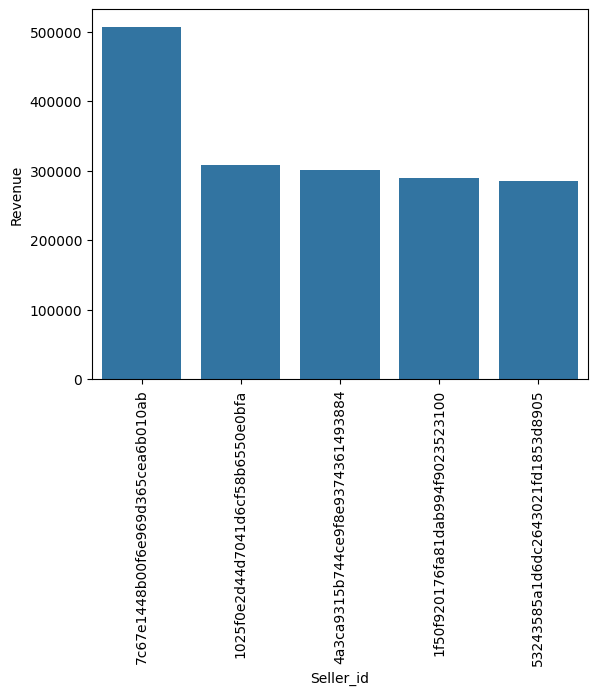

In [25]:
query = """select*,dense_rank() over(order by revenue desc) from (select order_items.seller_id,round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by  order_items.seller_id) as a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Seller_id","Revenue","Rank"])
df.head(10)
sns.barplot(x="Seller_id",y="Revenue",data=df.head())
plt.xticks(rotation=90)
plt.show()

# Advanced Queries

1. Calculate the moving average of order values for each customer over order history

In [30]:
query = """select customer_id,order_purchase_timestamp,payment,avg(payment) over(partition by customer_id order by
order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer Id","Time Stamps","Payment","Moving Average"])
df.head()

,Customer Id,Time Stamps,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 2. Calculate the cumulative sales per month for each year.

In [33]:
query = """Select years, months,payment,sum(payment) over(order by years,months) cumulative_Sales from
(Select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp)as months,round(sum(payments.payment_value),2) as Payment
from orders join payments
on orders.order_id=payments.order_id
group by years,months) as a;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Month","Payment","Cumulative Sales"])
df.head()

,Year,Month,Payment,Cumulative Sales
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69


3. Calculate the year over year growth rate of total sales.

In [49]:
query = """with a as(Select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as Payment
from orders join payments
on orders.order_id=payments.order_id
group by years order by years)


select years,payment,((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 from a """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Sales","Year Growth %"])
df

,Year,Sales,Year Growth %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


4.Calculate the retention rate of customers, defined as the percentage of customer who make another purchase within 6 months.

In [51]:
query = """with a as(select customers.customer_id,min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp>first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id;"""

cur.execute(query)

data=cur.fetchall()
data

# NO customer in data is repeated due to tthe reason it is showing as none

[(None,)]

5. Identify the top 3 customers who spent the most money in each year

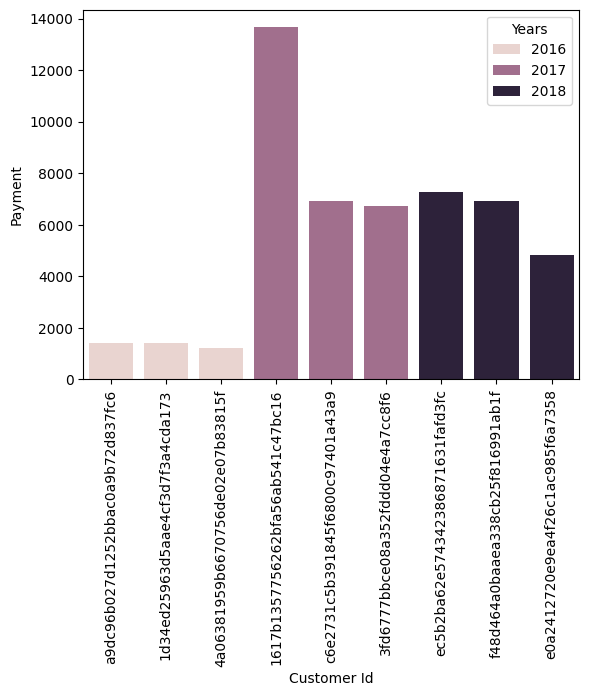

In [58]:
query = """select years,customer_id,payment,d_rank from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, round(sum(payments.payment_value),2) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id=payments.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as a where d_rank<=3;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Customer Id","Payment","Rank"])
sns.barplot(data=df,x="Customer Id",y="Payment",hue="Years")
plt.xticks(rotation=90)
plt.show()